In [4]:
import pandas as pd

df = pd.read_csv('versionInfo.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 12 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   filename                                      9 non-null      object
 1   version                                       9 non-null      object
 2   url                                           9 non-null      object
 3   description                                   9 non-null      object
 4   Type                                          9 non-null      object
 5   Associations with external schemes            9 non-null      object
 6   Available associations with external schemes  5 non-null      object
 7   Presence of controls/metrics                  9 non-null      object
 8   Focus/Anchor                                  9 non-null      object
 9   Number of controls/metrics                    9 non-null      int64 
 10  Part o

In [5]:
# Lista delle colonne da mantenere
cols_to_keep = [
    'filename',
    'Type',
    'Available associations with external schemes',
    'Focus/Anchor',
    'Number of controls/metrics',
    'Part of the old test data',
    'Included in new training data'
]

# Crea il nuovo dataframe filtrato
df = df[cols_to_keep]


df

,filename,Type,Available associations with external schemes,Focus/Anchor,Number of controls/metrics,Part of the old test data,Included in new training data
0,Cisco.csv,Controls,"SpanishENS.csv, EucsMedinaRequirements.csv, se...",Cisco,713,No,Yes
1,MEDINA_EUCS_MetricsMapping_Clean.csv,Controls,"BSI-C5.json, secnumcloud_controlsParsedAndTran...",EUCS,120,Yes,Yes
2,MEDINA_EUCS_ControlMapping_Clean_withText.csv,Controls,"BSI-C5.json, secnumcloud_controlsParsedAndTran...",EUCS,120,Yes,Yes
3,SpanishENS.csv,Controls,NaN,No,209,No,Yes
4,BSI-C5.json,Controls,NaN,No,294,Yes,No
5,secnumcloud_controlsParsedAndTranslatedEnglish...,Controls,NaN,No,287,No,Yes
6,medinaMetrics.csv,Metrics,EucsMedinaRequirements.csv,No,166,Yes,No
7,EucsMedinaRequirements.csv,Requirements/Controls,NaN,EUCS,70,Yes,No
8,fabasoftMetrics.csv,Metrics,"EucsMedinaRequirements.csv, BSI-C5.json",Fabasoft,57,No,Yes


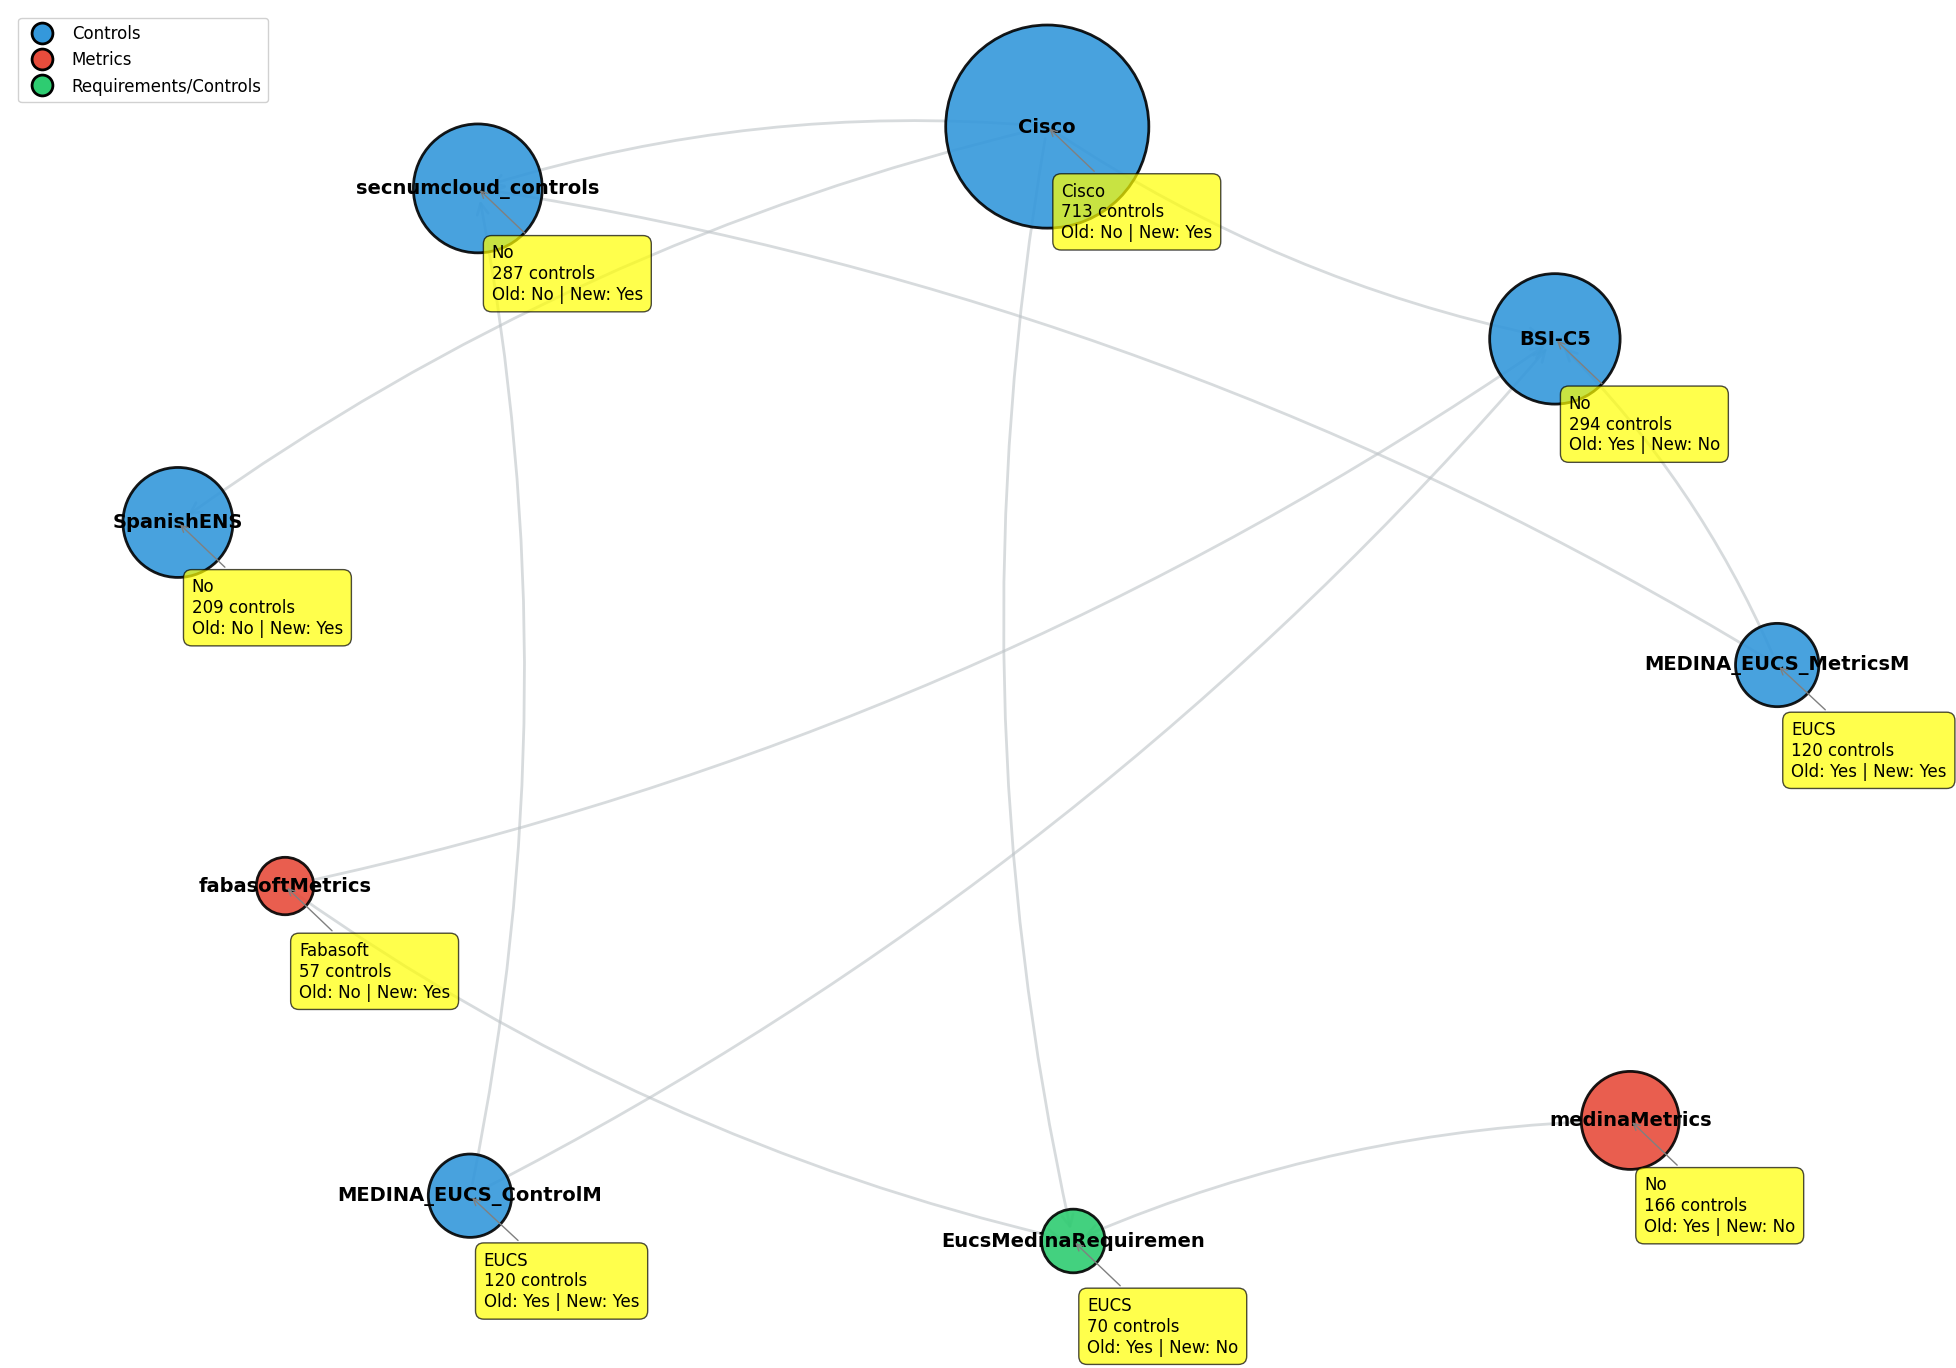


=== STATISTICHE DEL GRAFO ===
Numero di nodi: 9
Numero di archi: 11

Nodi con più connessioni:
  Cisco.csv: 4 connessioni
  BSI-C5.json: 4 connessioni
  secnumcloud_controlsParsedAndTranslatedEnglish.csv: 3 connessioni
  EucsMedinaRequirements.csv: 3 connessioni
  MEDINA_EUCS_MetricsMapping_Clean.csv: 2 connessioni
  MEDINA_EUCS_ControlMapping_Clean_withText.csv: 2 connessioni
  fabasoftMetrics.csv: 2 connessioni
  SpanishENS.csv: 1 connessioni
  medinaMetrics.csv: 1 connessioni


In [6]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyBboxPatch
import numpy as np

# Creazione del grafo diretto
G = nx.DiGraph()

# Aggiunta dei nodi con i loro attributi
for idx, row in df.iterrows():
    filename = row['filename']
    node_type = row['Type']
    focus = row['Focus/Anchor']
    n_controls = row['Number of controls/metrics']
    old_test = row['Part of the old test data'] 
    new_train =  row['Included in new training data']
    
    # Attributi del nodo
    G.add_node(filename, 
               type=node_type,
               focus=focus,
               n_controls=n_controls,
               old_test=old_test,
               new_train=new_train)

# Aggiunta degli archi basati su "Available associations"
for idx, row in df.iterrows():
    source = row['filename']
    associations = row['Available associations with external schemes']
    
    if pd.notna(associations) and associations != 'NaN':
        # Parsing delle associazioni
        assoc_list = [a.strip() for a in str(associations).split(',')]
        for target in assoc_list:
            # Trova il match nel dataframe
            for t_idx, t_row in df.iterrows():
                if target in t_row['filename'] or t_row['filename'] in target:
                    G.add_edge(source, t_row['filename'])

# Configurazione della visualizzazione
fig, ax = plt.subplots(figsize=(20, 14))

# Layout del grafo
pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

# Colori basati sul tipo
color_map = {
    'Controls': '#3498db',
    'Metrics': '#e74c3c',
    'Requirements/Controls': '#2ecc71'
}

node_colors = [color_map.get(G.nodes[node]['type'], '#95a5a6') for node in G.nodes()]

# Dimensioni basate sul numero di controlli
sizes = [G.nodes[node]['n_controls'] * 30 for node in G.nodes()]

# Disegna gli archi
nx.draw_networkx_edges(G, pos, edge_color='#bdc3c7', arrows=True, 
                       arrowsize=20, arrowstyle='->', width=2,
                       connectionstyle='arc3,rad=0.1', alpha=0.6, ax=ax)

# Disegna i nodi
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=sizes, 
                       alpha=0.9, ax=ax, edgecolors='black', linewidths=2)

# Aggiungi le etichette dei nodi
labels = {node: node.replace('.csv', '').replace('.json', '')[:20] 
          for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=14, font_weight='bold', ax=ax)

# Aggiungi informazioni dettagliate come annotazioni
for node, (x, y) in pos.items():
    info = G.nodes[node]
    text = f"{info['focus']}\n{info['n_controls']} controls\nOld: {info['old_test']} | New: {info['new_train']}"
    ax.annotate(text, xy=(x, y), xytext=(10, -80), 
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                fontsize=12, ha='left',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', 
                               color='gray', lw=1))

# Legenda
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', 
               markersize=15, label='Controls', markeredgecolor='black', markeredgewidth=2),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', 
               markersize=15, label='Metrics', markeredgecolor='black', markeredgewidth=2),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ecc71', 
               markersize=15, label='Requirements/Controls', markeredgecolor='black', markeredgewidth=2)
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12, framealpha=0.9)



ax.axis('off')
plt.tight_layout()
plt.show()

# Stampa statistiche
print("\n=== STATISTICHE DEL GRAFO ===")
print(f"Numero di nodi: {G.number_of_nodes()}")
print(f"Numero di archi: {G.number_of_edges()}")
print(f"\nNodi con più connessioni:")
for node, degree in sorted(G.degree(), key=lambda x: x[1], reverse=True):
    print(f"  {node}: {degree} connessioni")